**Wallmart Weekly Sales Data Set Study** \

in this notebook we are trying to study the sales of Walmart and answer 3 questions:\
1- What is the effect of seasonality on store sales?\
2- What are the main factors that affect the weekly sales?\
3- What are the most compelling insights in this dataset? \

This notebook studies the different effects on weekly sales of Walmart all over the US/

the data consist of three main parts, weekly sales per store per department, info about the stores, and general info about the period (CPI, tempreture, unemployment rate and  holidays during tha week).


In [1]:
#first we import the needed libraries and connect the driver where the data files are
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing
from sklearn.preprocessing import StandardScaler #for scaling
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from google.colab import drive
from sklearn.impute import SimpleImputer
import seaborn as sns
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Load the Dataset
features= pd.read_csv("/content/drive/My Drive/Colab Notebooks/features.csv")
stores=pd.read_csv("/content/drive/My Drive/Colab Notebooks/stores.csv")
test=pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv")
train=pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")


In [4]:
#let's try to take a look over the dataset
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [0]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [0]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


After we took a look over the data, let's check if the data, and how clean is it 

In [5]:
#Check Nulls
stores.isnull().sum()


Store    0
Type     0
Size     0
dtype: int64

In [6]:
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [0]:
#Dealing with Nulls, for CPI and unimployment we will take medians 
# and for markdowns we will replace nulls with zeros
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputer = imputer.fit(features[['CPI']])
features['CPI'] = imputer.transform(features[['CPI']])
imputer = imputer.fit(features[['Unemployment']])
features['Unemployment'] = imputer.transform(features[['Unemployment']])
features=features.fillna(0)

In [8]:
features['CPI']

0       211.096358
1       211.242170
2       211.289143
3       211.319643
4       211.350143
           ...    
8185    182.764003
8186    182.764003
8187    182.764003
8188    182.764003
8189    182.764003
Name: CPI, Length: 8190, dtype: float64

now we will join the data togather to have a full look on the data set we have
then we will look if we need to deal with any of the columns

In [0]:
#df creation and joining Features
df=train
df=df.join(stores.set_index('Store'), on='Store')
df['store_date']=df['Store'].astype(str)+df['Date']
features['store_date']=features['Store'].astype(str)+features['Date']
features=features.drop(['Store','Date','IsHoliday'],axis=1)
df=df.merge(features,left_on='store_date',right_on='store_date')
df=df.rename(columns={"Type": "store_type", "Size": "store_size"})
df=df.rename(str.lower, axis='columns')

In [0]:
# creating an identifier
df['store_date_dep']=df['store_date']+df['dept'].astype(str)
df=df.drop(['store','dept','date','store_date'],axis=1)

In [12]:
#arranging columns
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

,unemployment,store_date_dep,weekly_sales,isholiday,store_type,store_size,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi
0,8.106,12010-02-051,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358
1,8.106,12010-02-052,50605.27,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358
2,8.106,12010-02-053,13740.12,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358
3,8.106,12010-02-054,39954.04,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358
4,8.106,12010-02-055,32229.38,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358


In [0]:
# Dealing with categorical Columns
df['isholiday']=df['isholiday'].map({True:1,False:0})

In [0]:
df['store_type']=df['store_type'].map({'A':0,'B':1,'C':2})

In [15]:
df.head()

,unemployment,store_date_dep,weekly_sales,isholiday,store_type,store_size,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi
0,8.106,12010-02-051,24924.50,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358
1,8.106,12010-02-052,50605.27,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358
2,8.106,12010-02-053,13740.12,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358
3,8.106,12010-02-054,39954.04,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358
4,8.106,12010-02-055,32229.38,0,0,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358


now we can start on looking for answeres for our questions,
let us start by the first question:\
What is the effect of seasonality on store sales?


In [0]:
def graphs (df,column):
  '''
    input:  (df, the name of the column we want to graph vs weekly sales)
    plot ....
    output: (the graph of selected columns vs weekly sales)
    '''
  plt.figure()
  plt.scatter(df[column] , df['weekly_sales'])
  plt.ylabel('weekly_sales')
  plt.xlabel(column)

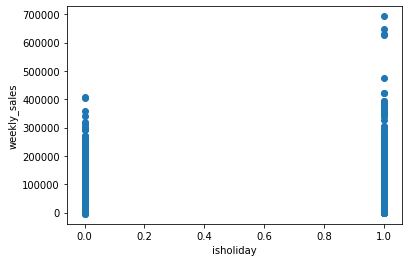

In [19]:
graphs(df,'isholiday')

In [0]:
df.groupby('isholiday')['weekly_sales'].mean()

isholiday
0    15901.445069
1    17035.823187
Name: weekly_sales, dtype: float64

we see here how that during holidays we have more sales than other weeks

to answer the second question (the main factors that affect the weekly sales) let us draw the different columns againest the weekly sales and see if we can notice any relations

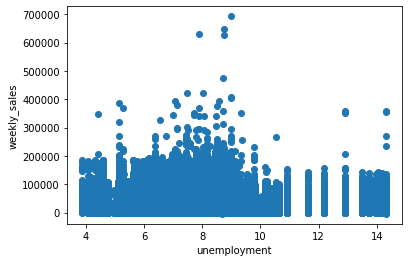

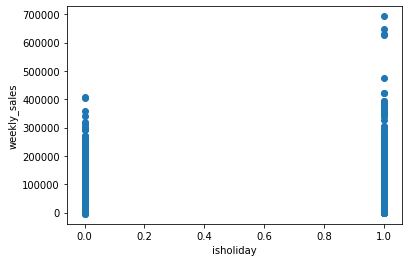

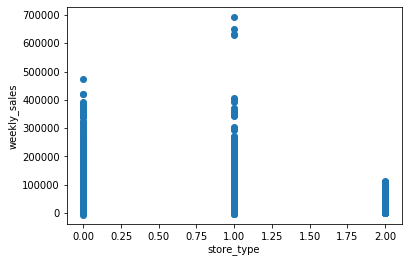

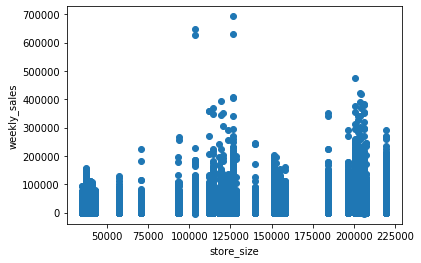

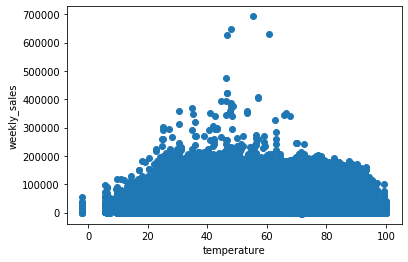

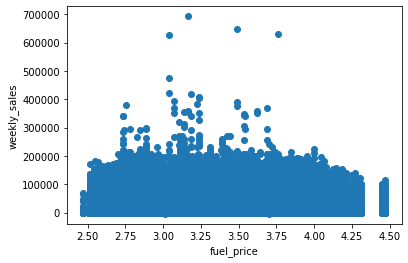

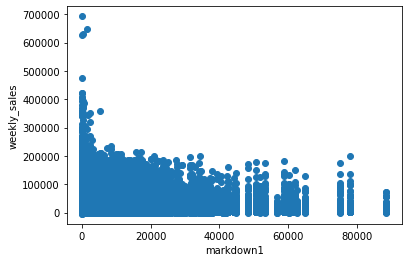

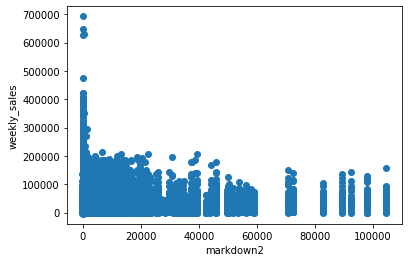

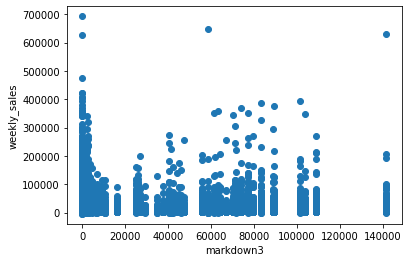

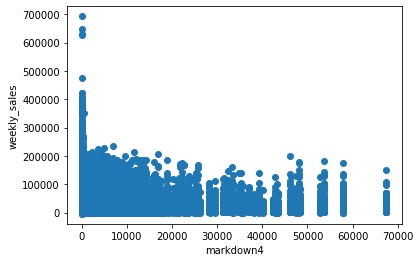

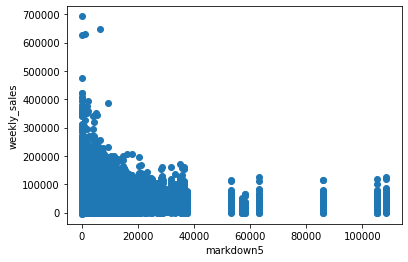

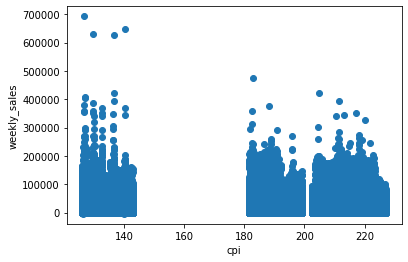

In [20]:
for column in df.columns.tolist():
    if column == 'weekly_sales':
        continue
    elif column == 'store_date_dep':
        continue
    else:
        graphs(df,column)

from the graphs above we see the clear relations of weekly sales with temperature, CPI, store type, and unemployment rate.

to go further and try to gather more insights from the data to answer our third questions we will try to draw graphs for all the columns againest each other

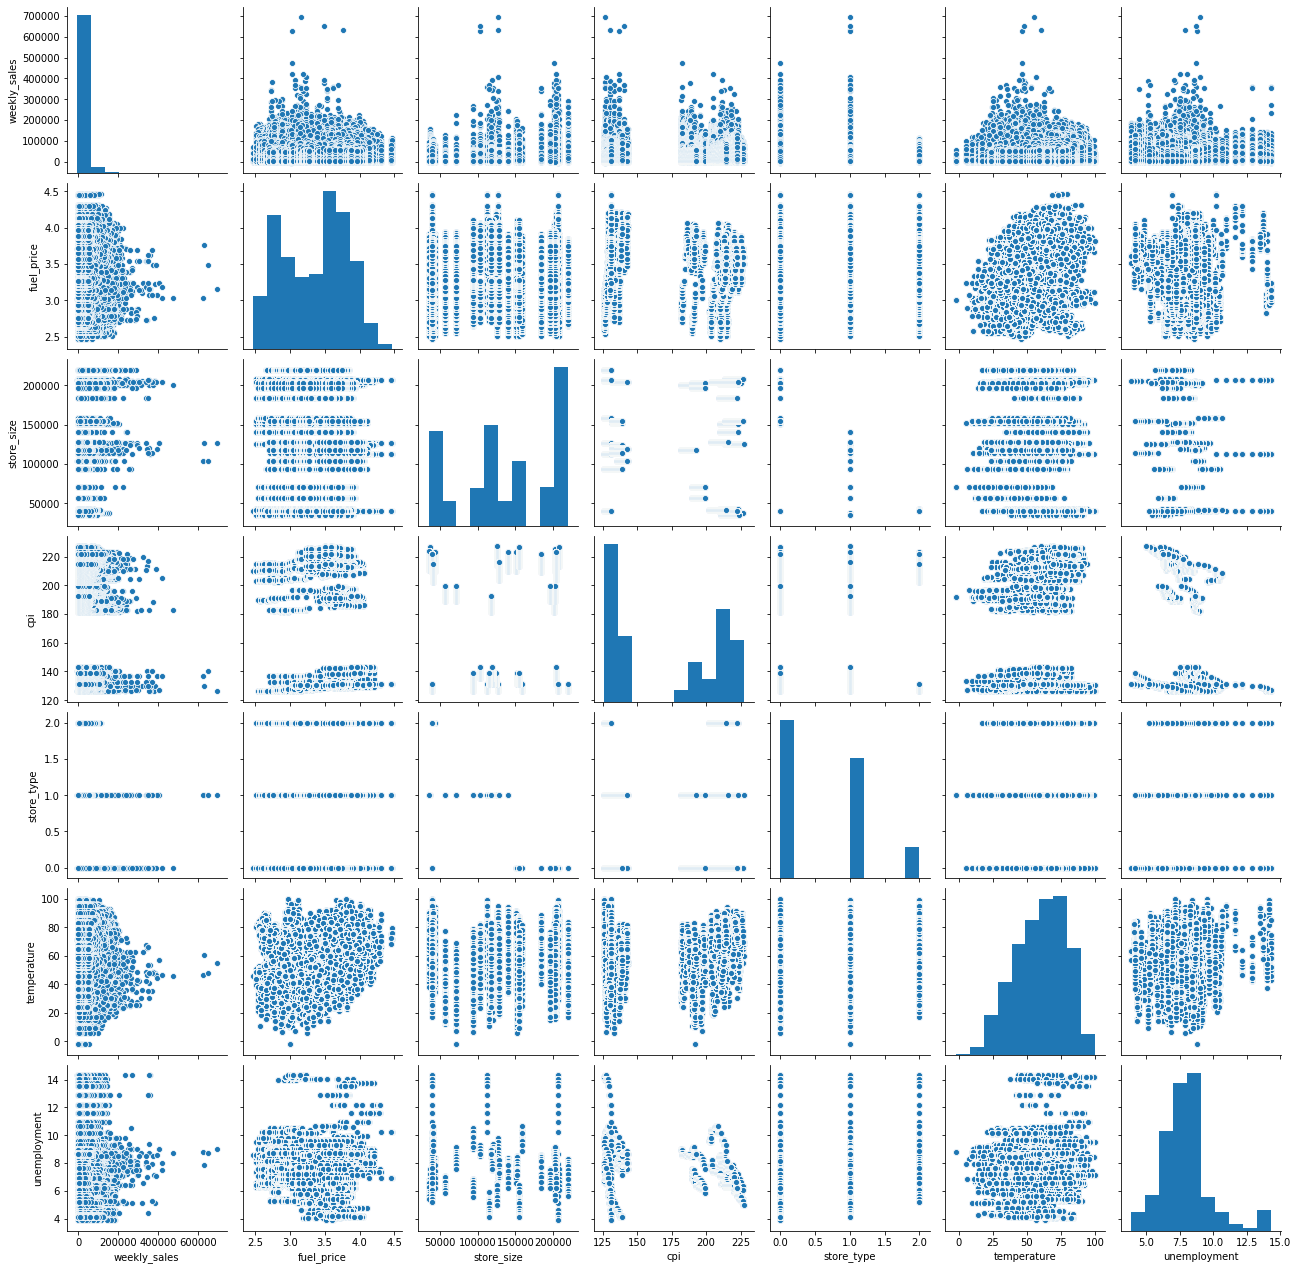

In [0]:
sns.pairplot(df, vars=['weekly_sales', 'fuel_price', 'store_size', 'cpi', 'store_type', 'temperature', 'unemployment'])

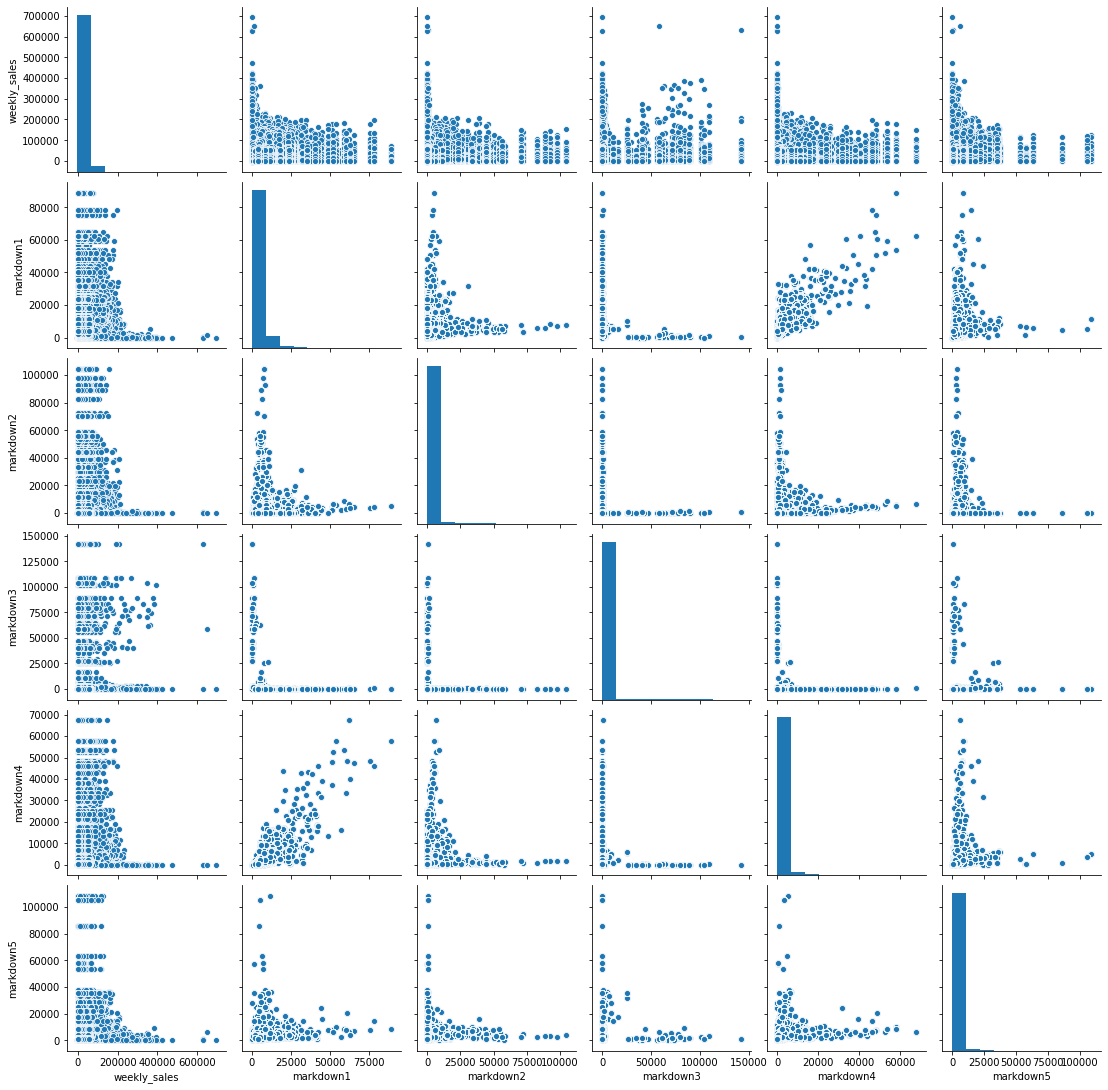

In [0]:
sns.pairplot(df, vars=['weekly_sales', 'markdown1', 'markdown2', 'markdown3', 'markdown4', 'markdown5'])

It seems that weekly sales are affected by different reasons. So, people tend to buy more from Walmart during periods of moderate temperatures during holidays, when the prices are low, from large stores and particular types of stores.